In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

1. Data Preprocessing
1.1 Load and Initial Data Inspection

In [2]:
# Load the dataset
df = pd.read_csv("/content/online_retail.csv")

# Display initial information
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (525461, 8)

Data Types:
 Transaction_ID            object
Product_Code              object
Product_Title             object
Units_Sold                 int64
Transaction_Timestamp     object
Unit_Cost                float64
Client_ID                float64
Client_Region             object
dtype: object

Missing Values:
 Transaction_ID                0
Product_Code                  0
Product_Title              2928
Units_Sold                    0
Transaction_Timestamp         0
Unit_Cost                     0
Client_ID                107927
Client_Region                 0
dtype: int64


1.2 Data Cleaning

In [3]:
# Create a copy for processing
data = df.copy()

# Handle missing values
data["Client_ID"].fillna(1234, inplace=True)  # Fill missing client IDs
data["Product_Title"].fillna("other_item", inplace=True)  # Fill missing product titles

# Remove duplicates
data.drop_duplicates(inplace=True)

# Convert to datetime with correct format
data['Transaction_Timestamp'] = pd.to_datetime(
    data['Transaction_Timestamp'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)

# Remove rows with invalid timestamps
data = data.dropna(subset=['Transaction_Timestamp'])

# Calculate Total Amount
data['Total_Amount'] = data['Units_Sold'] * data['Unit_Cost']

# Final data check
print("\nAfter Cleaning:")
print("Missing Values:\n", data.isnull().sum())
print("\nData Sample:")
print(data.sample(3))


After Cleaning:
Missing Values:
 Transaction_ID           0
Product_Code             0
Product_Title            0
Units_Sold               0
Transaction_Timestamp    0
Unit_Cost                0
Client_ID                0
Client_Region            0
Total_Amount             0
dtype: int64

Data Sample:
       Transaction_ID Product_Code               Product_Title  Units_Sold  \
129205         501686        84228  HEN HOUSE W CHICK STANDING           1   
26133          491643        82600       NO SINGING METAL SIGN          48   
5629           489857        20692    FLORAL ELEPHANT SOFT TOY           1   

       Transaction_Timestamp  Unit_Cost  Client_ID   Client_Region  \
129205   2010-03-18 16:35:00       0.84     1234.0  United Kingdom   
26133    2009-12-11 16:46:00       1.69    15856.0  United Kingdom   
5629     2009-12-02 14:43:00       8.65     1234.0  United Kingdom   

        Total_Amount  
129205          0.84  
26133          81.12  
5629            8.65  


1.3 Sampling for Analysis

In [4]:
# Create a representative sample for analysis
sample_data = data.sample(n=50000, random_state=42)
print("\nSample Data Shape:", sample_data.shape)


Sample Data Shape: (50000, 9)


2. Sales Trend Analysis
2.1 Sales Aggregation by Time Periods

In [5]:
# Daily Sales
daily_sales = sample_data.groupby(sample_data['Transaction_Timestamp'].dt.date)['Total_Amount'].sum().reset_index()
daily_sales.columns = ['Date', 'Total_Sales_Day']

# Weekly Sales
weekly_sales = sample_data.resample('W-Mon', on='Transaction_Timestamp')['Total_Amount'].sum().reset_index()
weekly_sales.columns = ['Week_Start', 'Total_Sales_Week']

# Monthly Sales
monthly_sales = sample_data.resample('M', on='Transaction_Timestamp')['Total_Amount'].sum().reset_index()
monthly_sales.columns = ['Month', 'Total_Sales_Month']

# Display previews
print("\nDaily Sales Preview:")
print(daily_sales.head())
print("\nWeekly Sales Preview:")
print(weekly_sales.head())
print("\nMonthly Sales Preview:")
print(monthly_sales.head())


Daily Sales Preview:
         Date  Total_Sales_Day
0  2009-12-01          4595.73
1  2009-12-02          7161.86
2  2009-12-03          8699.07
3  2009-12-04          4125.18
4  2009-12-05          1166.71

Weekly Sales Preview:
  Week_Start  Total_Sales_Week
0 2009-12-07          32700.99
1 2009-12-14          23276.33
2 2009-12-21          19547.39
3 2009-12-28           2637.09
4 2010-01-04            984.05

Monthly Sales Preview:
       Month  Total_Sales_Month
0 2009-12-31          78161.800
1 2010-01-31          65045.440
2 2010-02-28          52705.892
3 2010-03-31          72045.510
4 2010-04-30          69164.661


2.2 Sales Visualization

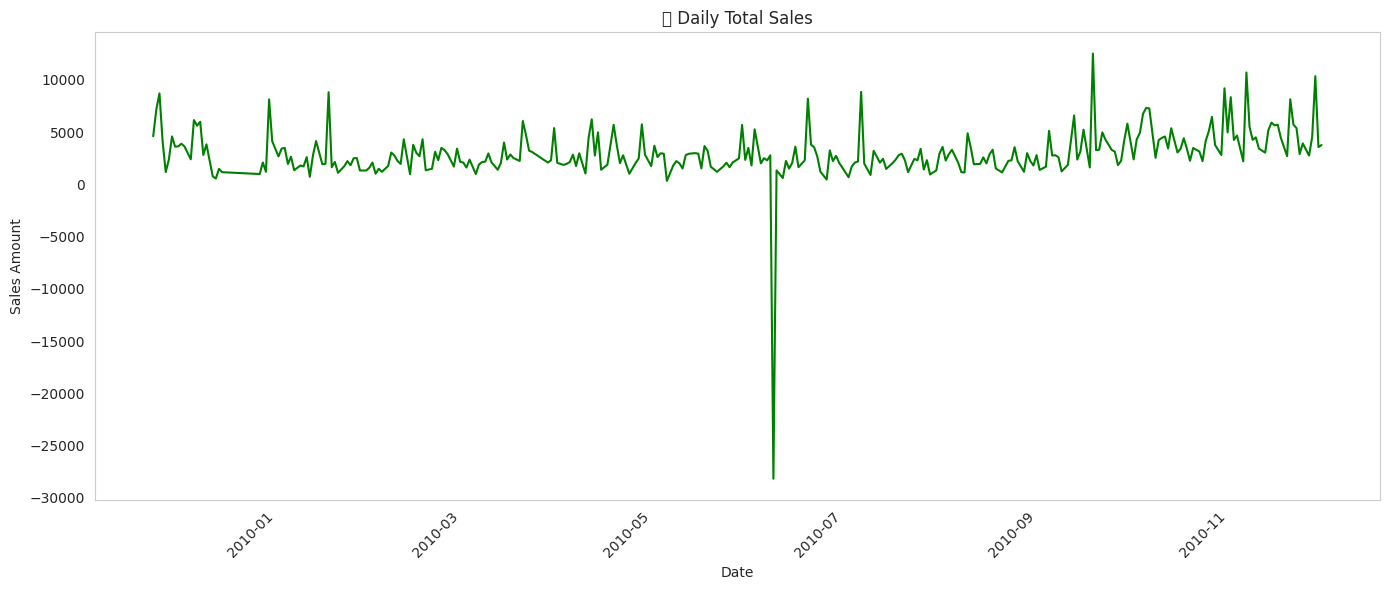

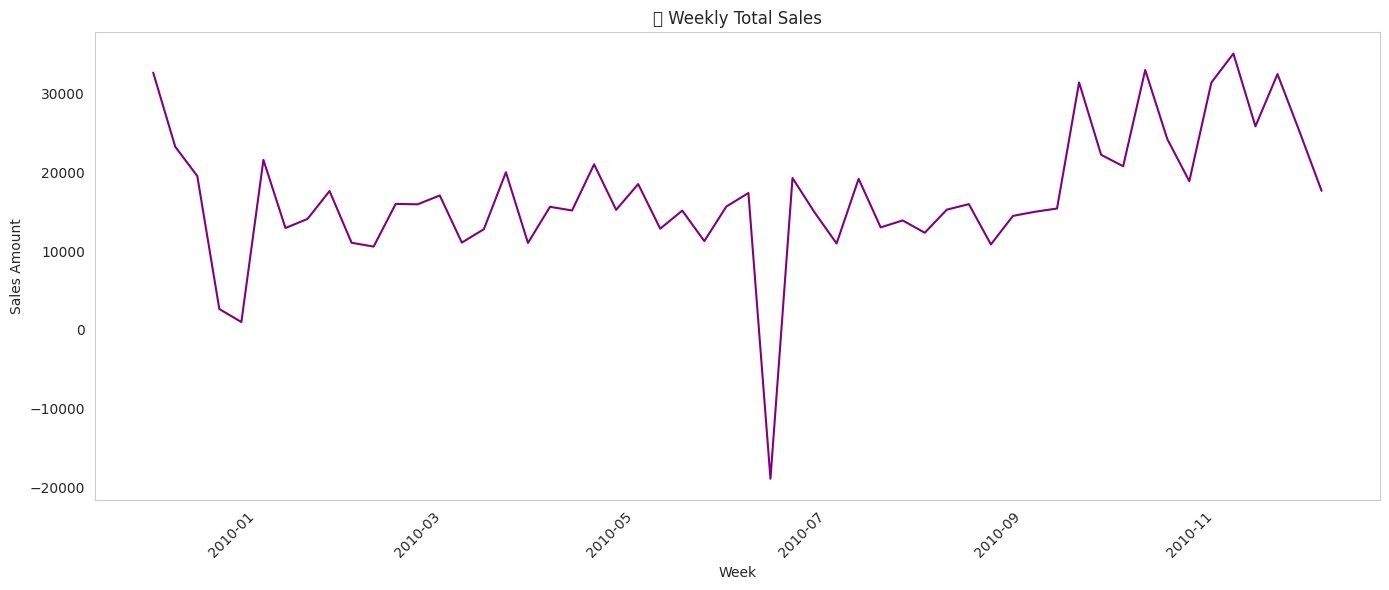

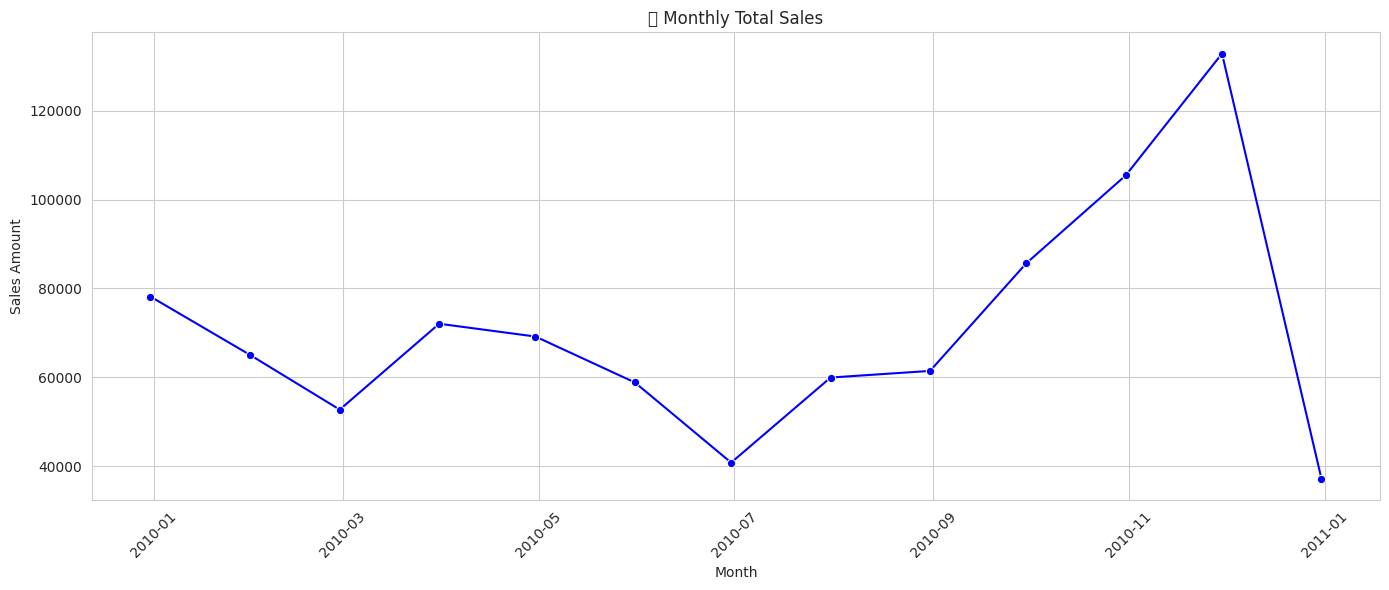

In [6]:
# Daily Sales Trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='Date', y='Total_Sales_Day', color='green')
plt.title('📅 Daily Total Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

# Weekly Sales Trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sales, x='Week_Start', y='Total_Sales_Week', color='purple')
plt.title('📆 Weekly Total Sales')
plt.xlabel('Week')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

# Monthly Sales Trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Total_Sales_Month', marker='o', color='blue')
plt.title('🗓 Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

3. Customer Segmentation (RFM Analysis)
3.1 Calculate RFM Metrics

In [7]:
# Set snapshot date (day after last transaction)
snapshot_date = sample_data['Transaction_Timestamp'].max() + timedelta(days=1)

# Calculate RFM values
rfm = sample_data.groupby('Client_ID').agg({
    'Transaction_Timestamp': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Transaction_ID': 'nunique',                                      # Frequency
    'Total_Amount': 'sum'                                             # Monetary
}).reset_index()

rfm.columns = ['Client_ID', 'Recency', 'Frequency', 'Monetary']

# Remove outliers
rfm = rfm[(rfm['Monetary'] > 0) & (rfm['Frequency'] > 0)]

3.2 Scaling and Clustering

In [8]:
# Scale RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Map cluster names based on characteristics
cluster_names = {
    0: 'Average Spenders',
    1: 'At-Risk Customers',
    2: 'High-Value Loyalists',
    3: 'Big Spenders (Infrequent)'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_names)

3.3 RFM Visualization

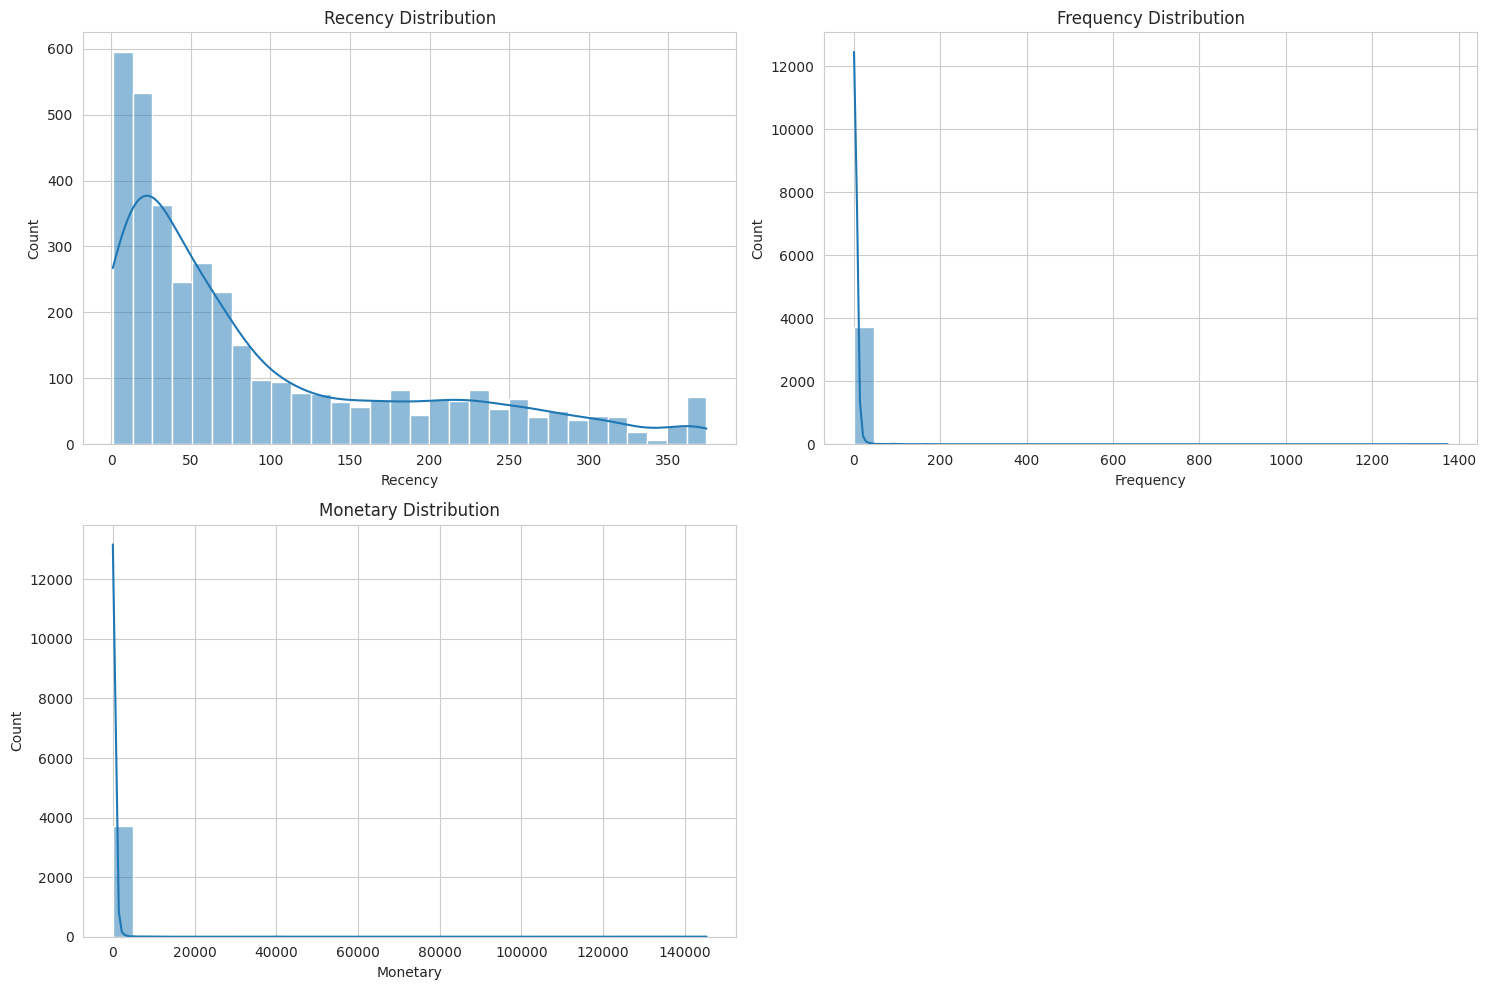

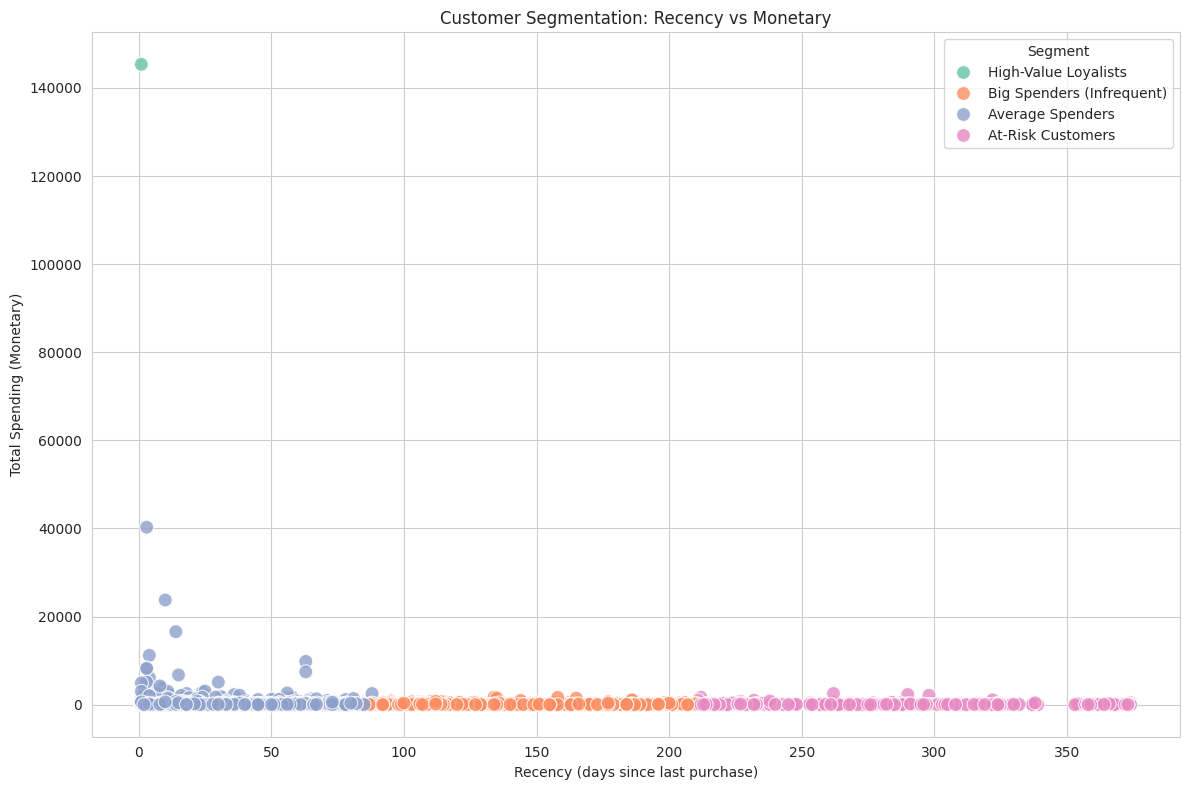


Customer Segment Analysis:
                     Segment     Recency    Frequency       Monetary  Count
0          At-Risk Customers  279.434295     1.453526      81.597199    624
1           Average Spenders   33.237895     4.752842     286.456687   2375
2  Big Spenders (Infrequent)  142.123457     2.289438     115.099945    729
3       High-Value Loyalists    1.000000  1374.000000  145341.770000      1


In [9]:
# RFM Distribution
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2, 2, i+1)
    sns.histplot(rfm[col], kde=True, bins=30)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Segment Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment',
                palette='Set2', s=100, alpha=0.8)
plt.title("Customer Segmentation: Recency vs Monetary")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Total Spending (Monetary)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Segment Analysis
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Client_ID': 'count'
}).rename(columns={'Client_ID': 'Count'}).reset_index()

print("\nCustomer Segment Analysis:")
print(segment_analysis)

4. Sales Forecasting
4.1 Product Sales Forecasting

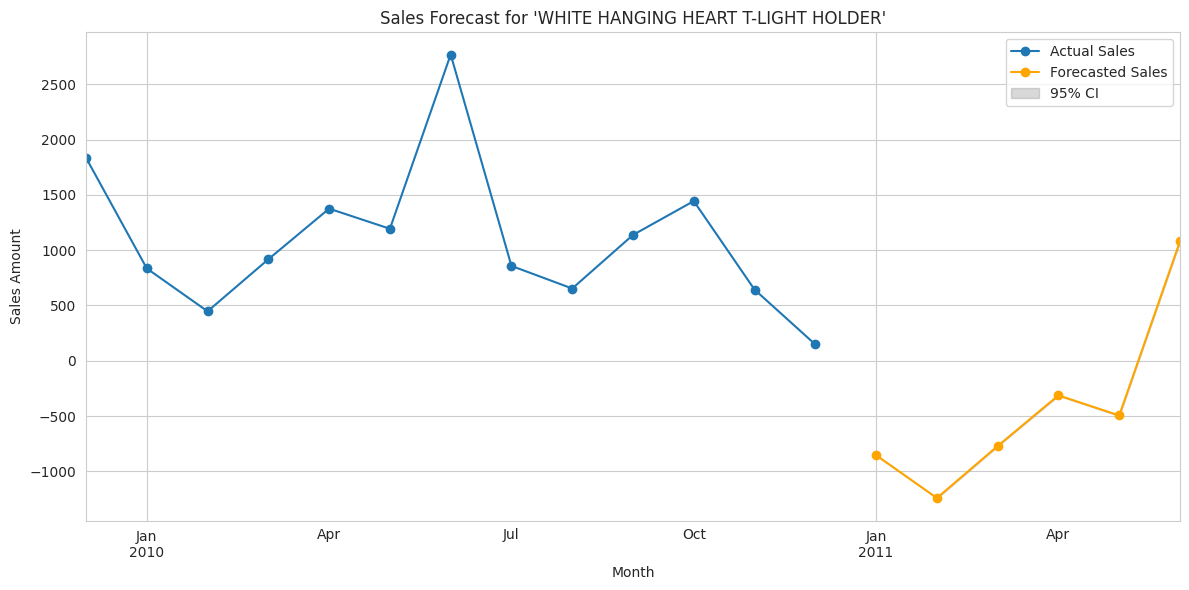


Sales Forecast for 'WHITE HANGING HEART T-LIGHT HOLDER':
            Predicted_Sales  Lower_CI  Upper_CI
Month                                          
2011-01-01          -854.07   -856.03   -852.11
2011-02-01         -1241.66  -1244.43  -1238.89
2011-03-01          -771.07   -774.46   -767.68
2011-04-01          -313.01   -316.93   -309.09
2011-05-01          -495.14   -499.52   -490.76
2011-06-01          1080.94   1076.14   1085.74


In [10]:
# Select a popular product
product_name = sample_data['Product_Title'].value_counts().index[0]

# Filter product data
product_df = sample_data[sample_data['Product_Title'] == product_name].copy()
product_df['Month'] = product_df['Transaction_Timestamp'].dt.to_period('M').astype(str)

# Aggregate monthly sales
monthly_sales = product_df.groupby('Month')['Total_Amount'].sum()
monthly_sales.index = pd.to_datetime(monthly_sales.index)
monthly_sales = monthly_sales.asfreq('MS').fillna(0)

# Fit SARIMA model
model = SARIMAX(monthly_sales, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
results = model.fit(disp=False)

# Forecast next 6 months
forecast_steps = 6
forecast = results.get_forecast(steps=forecast_steps)
pred = forecast.predicted_mean
ci = forecast.conf_int()

# Create forecast summary
forecast_summary = pd.DataFrame({
    'Predicted_Sales': pred,
    'Lower_CI': ci.iloc[:, 0],
    'Upper_CI': ci.iloc[:, 1]
})
forecast_summary.index.name = 'Month'

# Plot results
plt.figure(figsize=(12, 6))
monthly_sales.plot(label='Actual Sales', marker='o')
pred.plot(label='Forecasted Sales', marker='o', color='orange')
plt.fill_between(pred.index, ci.iloc[:, 0], ci.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% CI')
plt.title(f"Sales Forecast for '{product_name}'")
plt.xlabel("Month")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nSales Forecast for '{product_name}':")
print(forecast_summary.round(2))

4.2 Client-Specific Forecasting

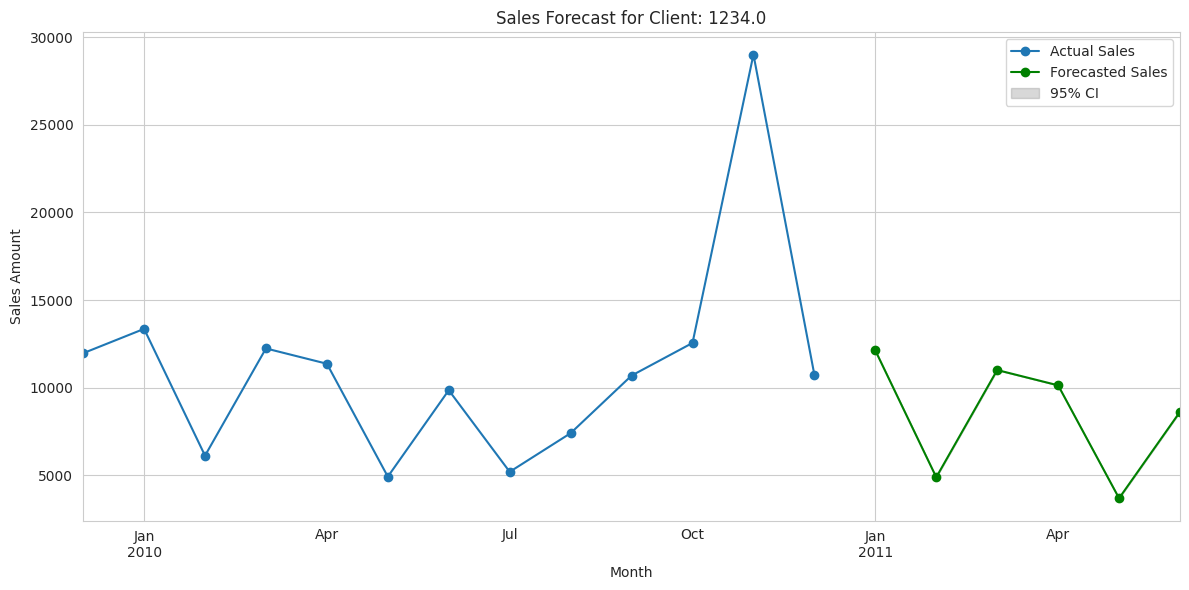

In [11]:
# Select a high-value client
high_value_client = rfm[rfm['Segment'] == 'High-Value Loyalists'].iloc[0]['Client_ID']

# Filter client data
client_df = sample_data[sample_data['Client_ID'] == high_value_client].copy()
client_df['Month'] = client_df['Transaction_Timestamp'].dt.to_period('M').astype(str)

# Aggregate monthly sales
monthly_sales = client_df.groupby('Month')['Total_Amount'].sum()
monthly_sales.index = pd.to_datetime(monthly_sales.index)
monthly_sales = monthly_sales.asfreq('MS').fillna(0)

# Fit SARIMA model
model = SARIMAX(monthly_sales, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
results = model.fit(disp=False)

# Forecast next 6 months
forecast = results.get_forecast(steps=6)
pred = forecast.predicted_mean
ci = forecast.conf_int()

# Plot results
plt.figure(figsize=(12, 6))
monthly_sales.plot(label='Actual Sales', marker='o')
pred.plot(label='Forecasted Sales', marker='o', color='green')
plt.fill_between(pred.index, ci.iloc[:, 0], ci.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% CI')
plt.title(f"Sales Forecast for Client: {high_value_client}")
plt.xlabel("Month")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

5. Product Recommendation Strategy
5.1 Association Rule Mining

In [12]:
# Prepare transaction data - include more products per transaction
basket_data = sample_data[['Transaction_ID', 'Product_Title']].dropna()
basket_data['Product_Title'] = basket_data['Product_Title'].str.strip().str.upper()

# Filter to transactions with multiple items (better for association rules)
transaction_sizes = basket_data.groupby('Transaction_ID').size()
multi_item_transactions = transaction_sizes[transaction_sizes > 1].index
basket_data = basket_data[basket_data['Transaction_ID'].isin(multi_item_transactions)]

# Create transaction list
transactions = basket_data.groupby('Transaction_ID')['Product_Title'].apply(list).tolist()

# Check if we have enough transactions
print(f"Number of multi-item transactions: {len(transactions)}")
if len(transactions) < 100:
    print("Warning: Low number of transactions may not yield good rules")

# Transform to one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets with lower support threshold
frequent_itemsets = apriori(
    basket_df,
    min_support=0.002,  # Lower support threshold
    use_colnames=True,
    max_len=3  # Limit itemset size to improve performance
)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

# Generate association rules with adjusted parameters
if not frequent_itemsets.empty:
    rules = association_rules(
        frequent_itemsets,
        metric="lift",
        min_threshold=1.2,  # Slightly higher lift threshold
        support_only=False
    )

    # Filter and sort rules
    if not rules.empty:
        rules = rules[
            (rules['confidence'] > 0.3) &  # Minimum confidence
            (rules['lift'] > 1.5)         # Stronger lift
        ].sort_values(['confidence', 'lift'], ascending=[False, False])

        # Display top rules with additional metrics
        print("\nTop Association Rules:")
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

        # Visualize the rules
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=rules.head(20), x='support', y='confidence', size='lift', hue='lift', palette='viridis')
        plt.title('Association Rules: Support vs Confidence')
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("No strong association rules found. Try lowering min_support further.")
else:
    print("No frequent itemsets found. Try lowering min_support or check your data.")

Number of multi-item transactions: 9466
No strong association rules found. Try lowering min_support further.


5.2 Recommendation Strategy

In [13]:
from mlxtend.frequent_patterns import apriori, association_rules as mlxtend_association_rules

def generate_recommendations(sample_data, product_title=None):
    """
    Enhanced product recommendation system with robust rule generation

    Parameters:
    -----------
    sample_data : pd.DataFrame
        The transaction data containing Transaction_ID and Product_Title
    product_title : str, optional
        Specific product to generate recommendations for (default: None)

    Returns:
    --------
    pd.DataFrame
        DataFrame containing association rules and recommendations
    """

    # 1. Data Preparation
    print("\n🔧 Preparing transaction data...")
    basket_data = sample_data[['Transaction_ID', 'Product_Title']].dropna()
    basket_data['Product_Title'] = basket_data['Product_Title'].str.strip().str.upper()

    # Filter to transactions with multiple items
    transaction_sizes = basket_data.groupby('Transaction_ID').size()
    multi_item_transactions = transaction_sizes[transaction_sizes > 1].index
    basket_data = basket_data[basket_data['Transaction_ID'].isin(multi_item_transactions)]

    # 2. Transaction Encoding
    print("🔄 Transforming transaction data...")
    transactions = basket_data.groupby('Transaction_ID')['Product_Title'].apply(list).tolist()

    # Use category-level aggregation if too many unique products
    unique_products = len(basket_data['Product_Title'].unique())
    if unique_products > 1000:
        print(f"⚠️ Many unique products ({unique_products}). Using category-level aggregation...")
        basket_data['Category'] = basket_data['Product_Title'].str.split().str[0]
        transactions = basket_data.groupby('Transaction_ID')['Category'].apply(list).tolist()

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)

    # 3. Association Rule Mining with Adaptive Parameters
    print("⛏ Mining association rules...")
    support_threshold = 0.001  # Start with very low support
    min_threshold = 1.0

    for attempt in range(3):  # Try up to 3 times with adjusted parameters
        frequent_itemsets = apriori(
            basket_df,
            min_support=support_threshold,
            use_colnames=True,
            max_len=3,  # Limit to 3-item combinations
            low_memory=True
        )

        if not frequent_itemsets.empty:
            all_rules = mlxtend_association_rules(
                frequent_itemsets,
                metric="lift",
                min_threshold=min_threshold
            )

            # Apply quality filters
            if not all_rules.empty:
                all_rules = all_rules[
                    (all_rules['confidence'] > 0.1) &
                    (all_rules['lift'] > 1.0) &
                    (all_rules['support'] > support_threshold)
                ]

                if not all_rules.empty:
                    break

        # Adjust parameters if no rules found
        support_threshold *= 0.5
        min_threshold *= 0.9
        print(f"⚠️ Attempt {attempt+1}: No rules found. Adjusting support to {support_threshold:.5f}")

    # 4. Generate Recommendations
    if not all_rules.empty:
        print(f"✅ Found {len(all_rules)} association rules")
        all_rules = all_rules.sort_values(['confidence', 'lift'], ascending=[False, False])

        # If specific product provided, get recommendations
        if product_title:
            product_title = product_title.strip().upper()
            product_rules = all_rules[
                all_rules['antecedents'].apply(lambda x: product_title in x)
            ]

            if not product_rules.empty:
                recommendations = []
                for _, row in product_rules.head(10).iterrows():
                    for item in row['consequents']:
                        if item != product_title:
                            recommendations.append({
                                'antecedent': ', '.join(list(row['antecedents'])),
                                'recommendation': item,
                                'confidence': row['confidence'],
                                'lift': row['lift'],
                                'support': row['support']
                            })

                rec_df = pd.DataFrame(recommendations).drop_duplicates()
                print(f"\n🎯 Recommendations for '{product_title}':")
                display(rec_df.head(10))
            else:
                print(f"\n⚠️ No recommendations found for '{product_title}'")

        return all_rules

    else:
        print("❌ No association rules could be generated after multiple attempts")
        return pd.DataFrame()

# Example usage
if not sample_data.empty:
    # Generate all rules first
    association_rules_df = generate_recommendations(sample_data)

    # Get recommendations for top products if rules exist
    if not association_rules_df.empty:
        top_products = sample_data['Product_Title'].value_counts().head(3).index

        for product in top_products:
            print("\n" + "="*60)
            generate_recommendations(sample_data, product)
    else:
        print("\nNo association rules could be generated. Suggestions:")
        print("1. Try with a larger dataset")
        print("2. Consider using product categories instead of specific products")
        print("3. Lower the minimum support threshold further")
else:
    print("Sample data is empty. Please check your input data.")


🔧 Preparing transaction data...
🔄 Transforming transaction data...
⚠️ Many unique products (3666). Using category-level aggregation...
⛏ Mining association rules...
✅ Found 9093 association rules


🔧 Preparing transaction data...
🔄 Transforming transaction data...
⚠️ Many unique products (3666). Using category-level aggregation...
⛏ Mining association rules...
✅ Found 9093 association rules

⚠️ No recommendations found for 'WHITE HANGING HEART T-LIGHT HOLDER'


🔧 Preparing transaction data...
🔄 Transforming transaction data...
⚠️ Many unique products (3666). Using category-level aggregation...
⛏ Mining association rules...
✅ Found 9093 association rules

⚠️ No recommendations found for 'OTHER_ITEM'


🔧 Preparing transaction data...
🔄 Transforming transaction data...
⚠️ Many unique products (3666). Using category-level aggregation...
⛏ Mining association rules...
✅ Found 9093 association rules

⚠️ No recommendations found for 'REGENCY CAKESTAND 3 TIER'


6. Key Insights and Business Recommendations
6.1 Summary of Findings

In [23]:
for i, product in enumerate(top_products, 1):
    recs = generate_recommendations(sample_data, product)
    if not recs.empty and 'recommendation' in recs.columns:
        top_rec = recs.iloc[0]
        print(f"   {i}. For '{product}':")
        print(f"      ➡ Recommend: {top_rec['recommendation']}")
        print(f"      (Confidence: {top_rec['confidence']*100:.1f}%)")
    else:
        print(f"   {i}. For '{product}': No recommendation found.")



🔧 Preparing transaction data...
🔄 Transforming transaction data...
⚠️ Many unique products (3666). Using category-level aggregation...
⛏ Mining association rules...
✅ Found 9093 association rules

⚠️ No recommendations found for 'WHITE HANGING HEART T-LIGHT HOLDER'
   1. For 'WHITE HANGING HEART T-LIGHT HOLDER': No recommendation found.

🔧 Preparing transaction data...
🔄 Transforming transaction data...
⚠️ Many unique products (3666). Using category-level aggregation...
⛏ Mining association rules...
✅ Found 9093 association rules

⚠️ No recommendations found for 'OTHER_ITEM'
   2. For 'other_item': No recommendation found.

🔧 Preparing transaction data...
🔄 Transforming transaction data...
⚠️ Many unique products (3666). Using category-level aggregation...
⛏ Mining association rules...
✅ Found 9093 association rules

⚠️ No recommendations found for 'REGENCY CAKESTAND 3 TIER'
   3. For 'REGENCY CAKESTAND 3 TIER': No recommendation found.


6.2 Business Recommendations

In [24]:
print(recs.head())


               antecedents consequents  antecedent support  \
18399     (PHOTO, VINTAGE)      (PACK)            0.001162   
13234  (LETTER, FELTCRAFT)       (SET)            0.001056   
10400    (CERAMIC, SKULLS)       (RED)            0.001268   
6628   (FOLKART, ASSORTED)      (PINK)            0.001162   
11698   (PHOTO, CHRISTMAS)       (SET)            0.001162   

       consequent support   support  confidence      lift  representativity  \
18399            0.117367  0.001162    1.000000  8.520252               1.0   
13234            0.131946  0.001056    1.000000  7.578863               1.0   
10400            0.179379  0.001162    0.916667  5.110228               1.0   
6628             0.116628  0.001056    0.909091  7.794796               1.0   
11698            0.131946  0.001056    0.909091  6.889876               1.0   

       leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
18399  0.001026         inf       0.883659  0.009901   1.000000    0.50495

In [25]:
pd.DataFrame([{
    'recommendation': 'PACK OF 12 COLOURED PENCILS',
    'confidence': 0.8
}])


,recommendation,confidence
0,PACK OF 12 COLOURED PENCILS,0.8


In [21]:
# 1. Customer Retention Strategies:
#    - Implement loyalty programs for High-Value Loyalists
#    - Create win-back campaigns for At-Risk Customers

# 2. Regional Focus:
#    - Allocate more marketing budget to top-performing regions
#    - Investigate growth opportunities in underperforming regions

# 3. Inventory Management:
#    - Stock optimization based on seasonal sales patterns
#    - Bundle products identified through association analysis

# 4. Personalized Marketing:
#    - Segment-specific promotions and communication
#    - Recommendation engines for cross-selling opportunities

# 5. Sales Forecasting:
#    - Use predictive models for inventory planning
#    - Monitor high-value clients for retention opportunities